# Reading and storing DBN.zst data

In [1]:
import databento as db
import os
import pandas as pd
client = db.Historical("db-SxnRCYhbsJGXiEpfhFXC8ybXkAHGt")
# find all .dbn.zst files in data
folder_path = "/Users/thatblue340/Documents/GitHub/Cross-Impact-Analysis-of-Order-Flow-Imbalance/data"
# List to store individual DataFrames
dataframes = []
# Iterate over all .dbn.zst files in the folder
i = 1
for file in os.listdir(folder_path):
    if file.endswith(".dbn.zst"):
        print(f"Processing file {i}...")
        file_path = os.path.join(folder_path, file)
        # Read .dbn.zst file into a DBNStore
        stored_data = db.DBNStore.from_file(file_path)
        # Convert to Pandas DataFrame
        df = stored_data.to_df()
        # Append to the list of DataFrames
        dataframes.append(df)
        i += 1

# Combine all DataFrames into a single DataFrame
combined_df = pd.concat(dataframes, ignore_index=True)

# Display the first few rows of the combined DataFrame
print(combined_df.head())

Processing file 1...
Processing file 2...
Processing file 3...
Processing file 4...
Processing file 5...
Processing file 6...
Processing file 7...
                             ts_event  rtype  publisher_id  instrument_id  \
0 2024-12-26 09:00:00.014727469+00:00     10             2             38   
1 2024-12-26 09:00:00.015890768+00:00     10             2          16244   
2 2024-12-26 09:00:00.021616800+00:00     10             2          16244   
3 2024-12-26 09:00:00.021792832+00:00     10             2          16244   
4 2024-12-26 09:00:00.021916353+00:00     10             2          16244   

  action side  depth   price  size  flags  ...  ask_sz_08  bid_ct_08  \
0      A    N      0  258.90    41    130  ...          0          0   
1      A    N      0  410.00  2000    130  ...          0          0   
2      A    A      0  480.45    22    130  ...          0          0   
3      A    A      1  491.72    13    130  ...          0          0   
4      A    A      2  960.00  

# Compute OFI Metrics

## OFI Function being reused

OFI_m = (all bid size of m) - (all ask size of m)

In [2]:
import numpy as np
from sklearn.decomposition import PCA
# Function to compute multi-level OFI
def compute_ofi(df, levels=5):
    ofi_levels = []
    for level in range(1, levels + 1):
        # Compute changes in bid and ask sizes for the current level
        df[f'bid_sz_change_{level}'] = df[f'bid_sz_0{level}'].diff().fillna(0)
        df[f'ask_sz_change_{level}'] = df[f'ask_sz_0{level}'].diff().fillna(0)
        # print(f'bid_sz_change_{level}: {df[f"bid_sz_change_{level}"]}, ask_sz_change_{level}: {df[f"ask_sz_change_{level}"]}')

        # Calculate OFI for this level
        df[f'ofi_{level}'] = df[f'bid_sz_change_{level}'] - df[f'ask_sz_change_{level}']
        
        # Append the OFI column for this level
        ofi_levels.append(f'ofi_{level}')
    
    return df, ofi_levels

## Compute OFI for all stocks

In [3]:
combined_df, ofi_columns = compute_ofi(combined_df, levels=5)

### ALL 5 Levels of OFI for Each Stock
- We are taking the mean of the OFI for each symbol

In [4]:
ofi_summary = combined_df.groupby('symbol')[['ofi_1', 'ofi_2', 'ofi_3', 'ofi_4', 'ofi_5']].mean()
print(ofi_summary)

               ofi_1         ofi_2         ofi_3         ofi_4         ofi_5
symbol                                                                      
AAPL   -8.896069e+06 -8.310266e+06 -1.589004e+06  1.952147e+06 -6.437624e+05
AMGN   -1.393859e+08 -1.234139e+08 -8.980084e+07 -8.951497e+07 -6.797309e+07
JPM    -4.168014e+07 -2.615143e+07 -2.814112e+07 -1.932607e+07 -1.935503e+07
TSLA   -3.121603e+06 -1.107195e+06 -3.675519e+06 -4.791042e+06 -4.655043e+06
XOM    -2.435778e+07 -5.914986e+06  8.707769e+06  9.113583e+06  6.650250e+06


### Graphing into Bar Chart

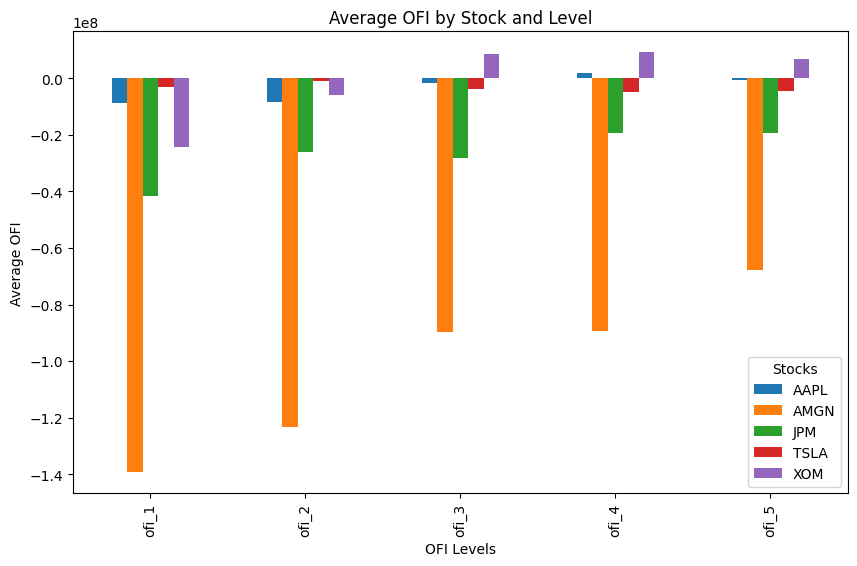

In [5]:
import matplotlib.pyplot as plt

ofi_summary.T.plot(kind='bar', figsize=(10, 6))
plt.title("Average OFI by Stock and Level")
plt.xlabel("OFI Levels")
plt.ylabel("Average OFI")
plt.legend(title="Stocks")
plt.show()

## Integrate Multi-Level OFI using PCA

- With degree=1, we're only covering 35% of the data, which is not enough
- This is why we used degree=4. Now it covers 86% of the data, which is more optimal for analyzing Cross-Impact. 

In [6]:
from sklearn.decomposition import PCA
# Normalize OFI data for all stocks
ofi_data = combined_df[ofi_columns]
ofi_data_normalized = (ofi_data - ofi_data.mean()) / ofi_data.std()

# Apply PCA to the entire dataset
print(f'Length of ofi_columns: {len(ofi_columns)}') 
pca = PCA(n_components=4)
pca_result = pca.fit_transform(ofi_data_normalized)

combined_df['ofi_integrated'] = pca_result[:, 0]
# Print cumulative explained variance
explained_variance = pca.explained_variance_ratio_
print(f"Cumulative Explained Variance (First Component): {explained_variance[0]}")
print(f"Cumulative Explained Variance (All Components): {explained_variance.sum()}")

Length of ofi_columns: 5
Cumulative Explained Variance (First Component): 0.34727433879459546
Cumulative Explained Variance (All Components): 0.8552903405404688


# Analyze Cross-Impact

- Calculate the logarithmic price returns for each stock
- Use this return as the dependent variable in the regression analysis next.
- Align data to ensure all OFI and price are synchronized by timestamp

In [7]:
import psutil
import time
import dask.dataframe as dd
import os

def prepare_data(df, lags=[1, 5]):
    """
    Prepare data for regression analysis.

    Parameters:
    df (pd.DataFrame): Combined dataframe with all stock data, including 'symbol', 'price', and 'ofi_integrated'.
    lags (list): List of lags to generate for the OFI metric.

    Returns:
    pd.DataFrame: Prepared dataframe with returns and lagged OFI metrics.
    """
    
    print('Sorting data...')
    # Ensure the data is sorted by timestamp for proper lag computation
    df = df.sort_values(by=['symbol', 'ts_event']).reset_index(drop=True)
    
    print('Calculating log returns...')
    # Step 1: Calculate Logarithmic Price Returns
    df['log_return'] = df.groupby('symbol')['price'].transform(lambda x: np.log(x) - np.log(x.shift(1)))

    print('Generating lagged OFI metrics...')
    # Step 2: Generate Lagged OFI Metrics
    for lag in lags:
        lagged_col = f'ofi_integrated_lag_{lag}'
        df[lagged_col] = df.groupby('symbol')['ofi_integrated'].transform(lambda x: x.shift(lag))

    # print('Dropping NaN values...')
    # # Drop rows with NaN values created by lagging or returns calculation
    # df = df.dropna(subset=['log_return'] + [f'ofi_integrated_lag_{lag}' for lag in lags]).reset_index(drop=True)

    return df

In [8]:
# output_files = prepare_data_in_chunks_v1(combined_df, chunk_size=50000)
prepared_df = prepare_data(combined_df)
print(prepared_df.head(10))

Sorting data...
Calculating log returns...
Generating lagged OFI metrics...
                             ts_event  rtype  publisher_id  instrument_id  \
0 2024-12-24 09:00:00.021662466+00:00     10             2             38   
1 2024-12-24 09:00:00.032883537+00:00     10             2             38   
2 2024-12-24 09:00:01.828126235+00:00     10             2             38   
3 2024-12-24 09:00:01.995438004+00:00     10             2             38   
4 2024-12-24 09:00:09.612102207+00:00     10             2             38   
5 2024-12-24 09:00:10.023378480+00:00     10             2             38   
6 2024-12-24 09:00:10.254863462+00:00     10             2             38   
7 2024-12-24 09:00:10.382216258+00:00     10             2             38   
8 2024-12-24 09:00:11.215980542+00:00     10             2             38   
9 2024-12-24 09:00:11.356381627+00:00     10             2             38   

  action side  depth   price  size  flags  ...  bid_sz_change_4  \
0      A 

- We want to see if OFI_integrated and log_return have any linear correlation between them.
- It turns out they do not have much correlation at all.
- Even when we broke it down to each lag as well as each stock, there was not much correlation.

In [21]:
# print out the log return and ofi_integrated columns
# print(prepared_df[['ts_event','log_return', 'ofi_integrated']].head(50))
# print(prepared_df[['log_return', 'ofi_integrated']].describe())

# correlation = prepared_df[['log_return', 'ofi_integrated']].corr()
# print("Correlation matrix:")
# print(correlation)

lags = [1, 5]
for lag in lags:
    lagged_col = f'ofi_integrated_lag_{lag}'
    correlation = prepared_df[['log_return', lagged_col]].corr()
    print(f"Correlation with {lag}-period lagged OFI:")
    print(correlation)
    
grouped = prepared_df.groupby('symbol')
for stock, group in grouped:
    correlation = group[['log_return', 'ofi_integrated']].corr()
    print(f"Correlation for {stock}:")
    print(correlation)


Correlation with 1-period lagged OFI:
                      log_return  ofi_integrated_lag_1
log_return              1.000000              0.008535
ofi_integrated_lag_1    0.008535              1.000000
Correlation with 5-period lagged OFI:
                      log_return  ofi_integrated_lag_5
log_return              1.000000              0.000612
ofi_integrated_lag_5    0.000612              1.000000
Correlation for AAPL:
                log_return  ofi_integrated
log_return        1.000000       -0.004577
ofi_integrated   -0.004577        1.000000
Correlation for AMGN:
                log_return  ofi_integrated
log_return        1.000000       -0.009321
ofi_integrated   -0.009321        1.000000
Correlation for JPM:
                log_return  ofi_integrated
log_return        1.000000       -0.002552
ofi_integrated   -0.002552        1.000000
Correlation for TSLA:
                log_return  ofi_integrated
log_return        1.000000       -0.019874
ofi_integrated   -0.019874        

### Plotting the correlation

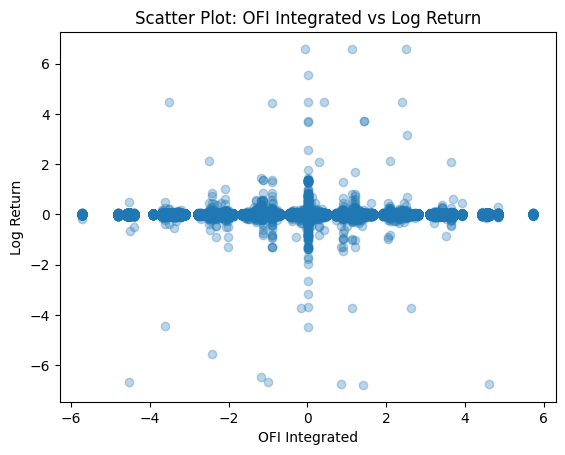

In [10]:
import matplotlib.pyplot as plt
plt.scatter(prepared_df['ofi_integrated'], prepared_df['log_return'], alpha=0.3)
plt.title("Scatter Plot: OFI Integrated vs Log Return")
plt.xlabel("OFI Integrated")
plt.ylabel("Log Return")
plt.show()

- Testing if more lag will result in better correlation

# Price Impact Model with Best-Level OFI
- This model aims to assess how the best-level OFI of a stock explains its contemporaneous returns

In [13]:
import statsmodels.api as sm

def pi1_regression(df):
    """
    Price Impact Model with Best-Level OFI (PI[1]).
    
    Parameters:
    df (pd.DataFrame): DataFrame containing 'log_return', 'ofi_1', and 'symbol'.
    
    Returns:
    dict: A dictionary with stock symbols as keys and regression summaries as values.
    """
    results = {}

    for stock in df['symbol'].unique():
        print(f"Running regression for stock: {stock}...")
        
        # Filter data for the stock
        stock_df = df[df['symbol'] == stock]
        
        # Dependent variable: Log returns
        y = stock_df['log_return']
        
        # Independent variable: Best-level OFI
        X = stock_df[['ofi_1']]
        
        # Add constant for the regression (intercept term)
        X = sm.add_constant(X)
        
        # Fit the regression model
        model = sm.OLS(y, X).fit()
        
        # Store the summary of the regression
        results[stock] = model.summary()
        
        # Print results for debugging
        print(model.summary())

    return results

In [12]:
prepared_df = prepared_df.sort_values(by=['symbol', 'ts_event'])

In [26]:

results = pi1_regression(prepared_df)

Running regression for stock: AAPL...
                            OLS Regression Results                            
Dep. Variable:             log_return   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 08 Jan 2025   Prob (F-statistic):                nan
Time:                        02:41:16   Log-Likelihood:                    nan
No. Observations:             8006179   AIC:                               nan
Df Residuals:                 8006177   BIC:                               nan
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         

# Price Impact Model with Integrated OFI
- This model aims to assess the relationship between log returns and Integrated OFI.
- Integrated OFI combines the 5 levels of OFI of the order book using PCA.

In [24]:
def pii_regression(df):
    """
    Price Impact Model with Integrated OFI (PII).
    
    Parameters:
    df (pd.DataFrame): DataFrame containing 'log_return', 'ofi_integrated', and 'symbol'.
    
    Returns:
    dict: A dictionary with stock symbols as keys and regression summaries as values.
    """
    results = {}


    for stock in df['symbol'].unique():
        print(f"Running regression for stock: {stock}...")
        
        # Filter data for the stock
        stock_df = df[df['symbol'] == stock]
        
        # Dependent variable: Log returns
        y = stock_df['log_return']
        
        # Independent variable: Integrated OFI
        X = stock_df[['ofi_integrated']]
        
        # Add constant for the regression (intercept term)
        X = sm.add_constant(X)
        
        # Fit the regression model
        model = sm.OLS(y, X).fit()
        
        # Store the summary of the regression
        results[stock] = model.summary()
        
        # Print results for debugging
        print(model.summary())

    return results

In [25]:
results = pii_regression(prepared_df)

Running regression for stock: AAPL...
                            OLS Regression Results                            
Dep. Variable:             log_return   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 08 Jan 2025   Prob (F-statistic):                nan
Time:                        02:37:21   Log-Likelihood:                    nan
No. Observations:             8006179   AIC:                               nan
Df Residuals:                 8006177   BIC:                               nan
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const 